In [2]:
from ggplot import *
import pandas as pd
import numpy as np


In [3]:
glass = pd.read_csv("glass.csv")
glass.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [62]:
X_train,X_test,y_train,y_test = train_test_split(glass.ix[:,:-1],glass[[-1]],random_state = 1)

First, let's have a visual look on the data:

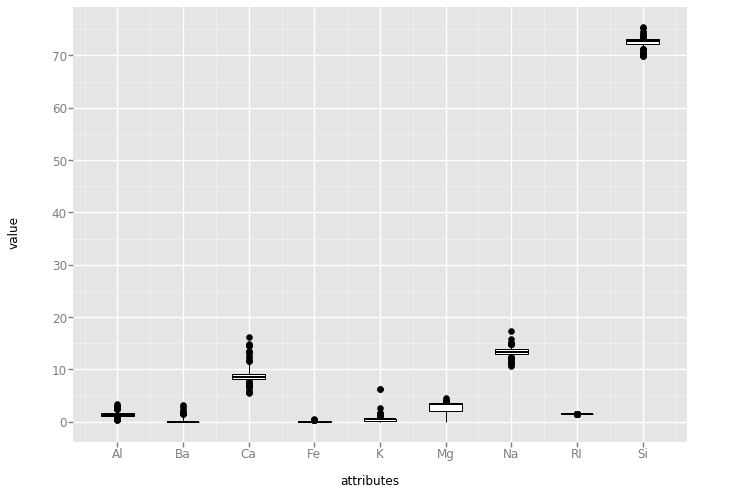

<ggplot: (19127237)>

In [61]:
glass_long = pd.melt(glass,id_vars ="Type",var_name = "attributes",value_name = "value")
ggplot(glass_long,aes("attributes","value"))+geom_boxplot()

Clearly, the data suffer from scaling issue, so let's scale the data first.

In [63]:
#scale the feature variables
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

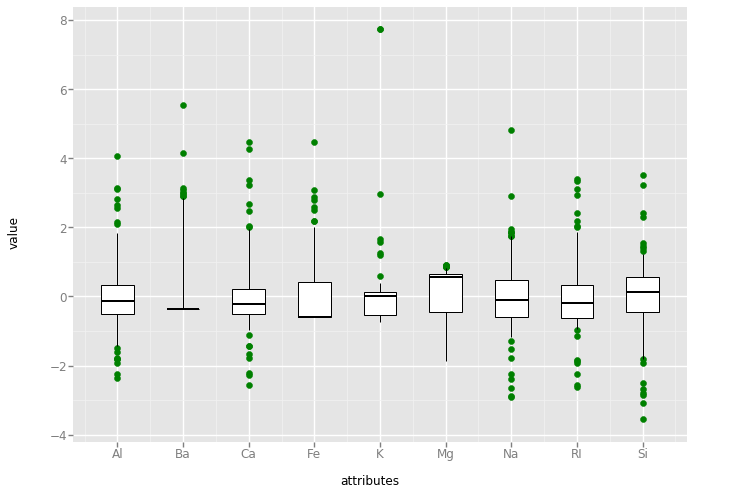

<ggplot: (16545729)>

In [8]:
X_train_df = pd.DataFrame(X_train, columns = ['RI','Na','Mg','Al','Si','K','Ca','Ba','Fe'])
# plot the train data after scaling
train_long = pd.melt(pd.DataFrame(X_train_df),var_name = "attributes",value_name = "value")
ggplot(train_long,aes("attributes","value"))+geom_boxplot(outlier_color = "green")

It's seems that the data has some outliers, however, since the data is highly skewed, the seemingly outliers could just represent the minority classes.

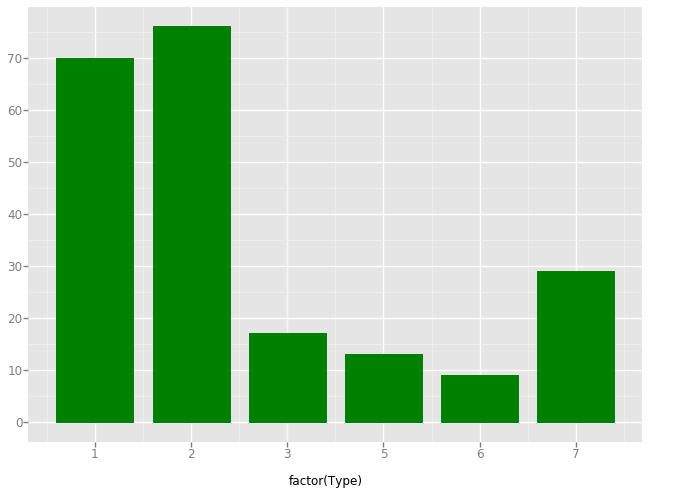

<ggplot: (23634219)>

In [117]:
ggplot(aes(x ="factor(Type)"),data = glass)+geom_bar(fill = "green")

We can from graph above that first two classes are really dominant in the dataset. Thus, we will not remove the seemly outliers for now.

In [65]:
y_train=y_train.as_matrix().reshape(160,)

Let's try 

In [79]:
from sklearn.svm import SVC
svc = SVC(kernel = "rbf",C = 90,gamma = 0.05)
svc.fit(X_train,y_train)
svc.score(X_test,y_test)

0.72222222222222221

In [12]:
y_pred = svc.predict(X_test)
from sklearn.metrics import f1_score
f1_score(y_test,y_pred,average="weighted")
#from sklearn.metrics import confusion_matrix
#print(confusion_matrix(y_test,y_pred))
#qplot(y_pred,y_test.as_matrix().reshape(54,))

C:\Users\Emrick\Anaconda3\envs\py2env\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.69264742934210732

In [26]:
from sklearn.metrics import make_scorer
f1score = make_scorer(f1_score,average = "weighted")

In [80]:
#k-fold cross validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = svc, X = X_train, y = y_train, cv = 5)
np.mean(accuracies)

0.73078431372549024

In [81]:
from sklearn.model_selection import GridSearchCV
par = [{"C":[50,100,150], "kernel":["linear","rbf"]},
      {"C":[70,80,90,100,200], "kernel":["rbf"], "gamma":[0.07,0.06,0.05,0.04,0.03]}]
grid_search = GridSearchCV(estimator = svc,
                          param_grid = par,
                          scoring = f1score,
                          cv = 5)
grid_search = grid_search.fit(X_train,y_train)
grid_search.best_score_

0.71821473461179342

In [28]:
grid_search.best_params_

{'C': 90, 'gamma': 0.05, 'kernel': 'rbf'}

In [60]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA(n_components = 9)
X_train = lda.fit_transform(X_train,y_train)
X_test = lda.transform(X_test)



In [53]:
svc = SVC(kernel = "rbf")
svc.fit(X_train,y_train)
svc.score(X_test,y_test)

0.29629629629629628

In [58]:
from sklearn.decomposition import KernelPCA
kpca = KernelPCA(n_components = 9, kernel = "rbf")
X_train = kpca.fit_transform(X_train)
X_test = kpca.transform(X_test)

KNN

In [66]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors = 5, metric = "minkowski", p = 2)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
f1_score(y_test,y_pred,average="weighted")

0.66830462681526515

In [76]:
from sklearn.model_selection import GridSearchCV
par = [{"n_neighbors":[2,3,4,5,10], "p":[1,2,3]},
      ]
grid_search = GridSearchCV(estimator = clf,
                          param_grid = par,
                          scoring = f1score,
                          cv = 5)
grid_search = grid_search.fit(X_train,y_train)
grid_search.best_score_

0.71464435906192481

In [77]:
grid_search.best_params_

{'n_neighbors': 3, 'p': 1}

In [83]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators = 10,criterion = "entropy",
                            random_state = 1)
rfc.fit(X_train,y_train)
y_pred = rfc.predict(X_test)
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[22,  0,  1,  0,  0,  0],
       [ 1, 15,  0,  0,  0,  0],
       [ 6,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  0],
       [ 0,  0,  0,  0,  1,  0],
       [ 0,  0,  0,  0,  0,  6]])

In [85]:
from sklearn.model_selection import GridSearchCV
par = [{"n_estimators":[5,10,100], "criterion":["entropy","gini"]},
    ]
grid_search = GridSearchCV(estimator = rfc,
                          param_grid = par,
                          scoring = f1score,
                          cv = 5)
grid_search = grid_search.fit(X_train,y_train)
grid_search.best_score_

0.77283405254965354

In [86]:
grid_search.best_params_

{'criterion': 'gini', 'n_estimators': 100}

In [95]:
rfc = RandomForestClassifier(n_estimators = 100,criterion = "gini",
                            random_state = 1)
rfc.fit(X_train,y_train)
y_pred = rfc.predict(X_test)
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = rfc, X = X_train, y = y_train, cv = 5,scoring = f1score)
(accuracies)

array([ 0.7376428 ,  0.74160469,  0.90350877,  0.71428571,  0.76727273])

In [94]:
f1_score(y_test,y_pred,average = 'weighted')

0.79755291005290996

In [89]:
confusion_matrix(y_test, y_pred)

array([[21,  1,  1,  0,  0,  0],
       [ 1, 13,  0,  0,  0,  2],
       [ 3,  2,  2,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  0],
       [ 0,  0,  0,  0,  1,  0],
       [ 0,  0,  0,  0,  0,  6]])

### detect whether windows

In [168]:
windows = glass.ix[(glass["Type"]==1)|(glass["Type"]==2)|(glass["Type"]==3)|(glass["Type"]==4)]
windows = windows.iloc[:,0:-1]

In [169]:
label_window = pd.Series(np.ones(163,dtype = "uint8"))
windows = pd.concat([windows,label_window],axis = 1)

In [171]:
windows = windows.rename(columns = {0:"Type"})

In [173]:
non_windows = glass.ix[(glass["Type"]==5)|(glass["Type"]==6)|(glass["Type"]==7)]
non_windows = non_windows.iloc[:,0:-1]

non_windows.index = np.arange(51)
non_windows.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
0,1.51514,14.01,2.68,3.50,69.89,1.68,5.87,2.2,0.0
1,1.51915,12.73,1.85,1.86,72.69,0.60,10.09,0.0,0.0
2,1.52171,11.56,1.88,1.56,72.86,0.47,11.41,0.0,0.0
3,1.52151,11.03,1.71,1.56,73.44,0.58,11.62,0.0,0.0
4,1.51969,12.64,0.00,1.65,73.75,0.38,11.53,0.0,0.0


In [174]:
label_non_window = pd.Series(np.zeros(51,dtype = "uint8"))
non_windows = pd.concat([non_windows,label_non_window],axis = 1)
non_windows = non_windows.rename(columns = {0:"Type"})


In [175]:
glass_1 = pd.concat([windows,non_windows],ignore_index= True)

In [177]:
X_train,X_test,y_train,y_test = train_test_split(glass_1.ix[:,:-1],glass_1[[-1]],random_state = 1)
#scale the feature variables
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)
y_train=y_train.as_matrix().reshape(160,)

In [178]:
from sklearn.svm import SVC
svc = SVC(kernel = "rbf",C = 90,gamma = 0.05)
svc.fit(X_train,y_train)
y_pred = svc.predict(X_test)
f1_score(y_test,y_pred,average="weighted")

0.9478940797687101

In [185]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = svc, X = X_train, y = y_train, cv = 5)
np.mean(accuracies)

0.94409213098729228

In [180]:
confusion_matrix(y_test, y_pred)

array([[ 8,  0],
       [ 3, 43]])

In [195]:
y_pred_t = rfc.predict(sc_X.transform(glass_1.ix[:,:-1]))
confusion_matrix(glass_1[[-1]],y_pred_t)

array([[ 51,   0],
       [  2, 161]])

In [193]:
rfc = RandomForestClassifier(n_estimators = 100,criterion = "gini",
                            random_state = 1)
rfc.fit(X_train,y_train)
y_pred = rfc.predict(X_test)
f1_score(y_test,y_pred,average="weighted")

0.96460905349794235

In [191]:
clf = KNeighborsClassifier(n_neighbors = 5, metric = "minkowski", p = 2)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
f1_score(y_test,y_pred,average="weighted")

0.96460905349794235

### Detect whether float

In [210]:
float_ = glass.ix[(glass["Type"]==1)|(glass["Type"]==3)]
float_ = float_.iloc[:,0:-1]
float_.index = np.arange(87)
label_float_ = pd.Series(np.ones(87,dtype = "uint8"))
float_ = pd.concat([float_,label_float_],axis = 1)
float_ = float_.rename(columns = {0:"Type"})


In [212]:
non_float_ = glass.ix[(glass["Type"]==2)]
non_float_ = non_float_.iloc[:,0:-1]
non_float_
non_float_.index = np.arange(76)
label_non_float_ = pd.Series(np.zeros(76,dtype = "uint8"))
non_float_ = pd.concat([non_float_,label_non_float_],axis = 1)
non_float_ = non_float_.rename(columns = {0:"Type"})


In [213]:
glass_f = pd.concat([float_,non_float_],ignore_index= True)
glass_f

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.00,0.00,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.00,0.00,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.00,0.00,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.00,0.00,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.00,0.00,1
5,1.51596,12.79,3.61,1.62,72.97,0.64,8.07,0.00,0.26,1
6,1.51743,13.30,3.60,1.14,73.09,0.58,8.17,0.00,0.00,1
7,1.51756,13.15,3.61,1.05,73.24,0.57,8.24,0.00,0.00,1
8,1.51918,14.04,3.58,1.37,72.08,0.56,8.30,0.00,0.00,1
9,1.51755,13.00,3.60,1.36,72.99,0.57,8.40,0.00,0.11,1


In [219]:
X_train,X_test,y_train,y_test = train_test_split(glass_f.ix[:,:-1],glass_f[[-1]],random_state = 1)
#scale the feature variables
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)
y_train = y_train.as_matrix().reshape(122,)

In [222]:
rfc = RandomForestClassifier(n_estimators = 100,criterion = "gini",
                            random_state = 1)
rfc.fit(X_train,y_train)
y_pred = rfc.predict(X_test)
f1_score(y_test,y_pred,average="weighted")

0.90243902439024393

In [231]:
y_pred_t = rfc.predict(sc_X.transform(glass_f.ix[:,:-1]))
confusion_matrix(glass_f[[-1]],y_pred_t)

array([[74,  2],
       [ 2, 85]])

In [225]:
confusion_matrix(y_test, y_pred)

array([[19,  2],
       [ 2, 18]])

In [226]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = svc, X = X_train, y = y_train, cv = 5)
np.mean(accuracies)

0.7543333333333333

In [227]:
from sklearn.svm import SVC
svc = SVC(kernel = "rbf",C = 90,gamma = 0.05)
svc.fit(X_train,y_train)
y_pred = svc.predict(X_test)
f1_score(y_test,y_pred,average="weighted")

0.82926829268292679

In [228]:
confusion_matrix(y_test, y_pred)

array([[17,  4],
       [ 3, 17]])

In [232]:
y_pred_t = svc.predict(sc_X.transform(glass_f.ix[:,:-1]))
confusion_matrix(glass_f[[-1]],y_pred_t)

array([[66, 10],
       [ 7, 80]])

In [234]:
clf = KNeighborsClassifier(n_neighbors = 3, metric = "minkowski", p = 1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
f1_score(y_test,y_pred,average="weighted")

0.85348432055749135

In [235]:
rfc.feature_importances_

array([ 0.13282887,  0.0592293 ,  0.21927569,  0.17335759,  0.07078087,
        0.12076437,  0.16544183,  0.00226993,  0.05605155])